In [1]:
#Model definition from models/off_tanet.py

import torch
from torch import nn
import numpy as np
from torchstat import stat

class Residual(nn.Module):
    def __init__(self,in_c,out_c):
        super(Residual,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = in_c,out_channels = out_c,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(in_channels = out_c,out_channels = out_c,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )
        self.botneck = nn.Conv2d(in_channels = in_c,out_channels = out_c,kernel_size = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        
    def forward(self,x):
        x_prim = x
        x = self.conv(x)
        x = self.botneck(x_prim) + x
        x = self.pool(x)
        return x

class SelfAttention(nn.Module):
    def __init__(self,in_c,out_c,fm_sz,pos_bias = False):
        super(SelfAttention,self).__init__()
        self.w_q = nn.Conv2d(in_channels = in_c,out_channels = out_c,kernel_size = 1)
        self.w_k = nn.Conv2d(in_channels = in_c,out_channels = out_c,kernel_size = 1)
        self.w_v = nn.Conv2d(in_channels = in_c,out_channels = out_c,kernel_size = 1)
        self.pos_code = self.__getPosCode(fm_sz,out_c)
        self.softmax = nn.Softmax(dim = 2)
        self.pos_bias = pos_bias

    def __getPosCode(self,fm_sz,out_c):
        x = []
        for i in range(fm_sz):
            x.append([np.sin,np.cos][i % 2](1 / (10000 ** (i // 2 / fm_sz))))
        x = torch.from_numpy(np.array([x])).float()
        return torch.cat([(x + x.t()).unsqueeze(0) for i in range(out_c)])
    
    def forward(self,x):
        q,k,v = self.w_q(x),self.w_k(x),self.w_v(x)
        pos_code = torch.cat([self.pos_code.unsqueeze(0) for i in range(x.shape[0])]).to(x.device)
        if self.pos_bias:
            att_map = torch.matmul(q,k.permute(0,1,3,2)) + pos_code
        else:    
            att_map = torch.matmul(q,k.permute(0,1,3,2)) + torch.matmul(q,pos_code.permute(0,1,3,2))
        am_shape = att_map.shape
        att_map = self.softmax(att_map.view(am_shape[0],am_shape[1],am_shape[2] * am_shape[3])).view(am_shape)
        return att_map,att_map * v

class MultiHeadSelfAttention(nn.Module):
    def __init__(self,in_c,out_c,head_n,fm_sz,pos_bias = False):
        super(MultiHeadSelfAttention,self).__init__()
        self.sa_blocks = [SelfAttention(in_c = in_c,out_c = out_c,fm_sz = fm_sz,pos_bias = pos_bias) for i in range(head_n)]
        self.sa_blocks = nn.ModuleList(self.sa_blocks)
        
    def forward(self,x):
        results = [sa(x)[1] for sa in self.sa_blocks]
        return torch.cat(results,dim = 1)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio = 2):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, 3, padding = 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim = 1, keepdim = True)
        max_out, _ = torch.max(x, dim = 1, keepdim = True)
        x = torch.cat([avg_out, max_out], dim = 1)
        x = self.conv1(x)
        return self.sigmoid(x)

class EnhancedResidual(nn.Module):
    def __init__(self,in_c,out_c,fm_sz,net_type = 'ta'):
        super(EnhancedResidual,self).__init__()
        self.net_type = net_type
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = in_c,out_channels = in_c,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(in_c),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = in_c,out_channels = out_c,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )
        self.botneck = nn.Conv2d(in_channels = in_c,out_channels = out_c,kernel_size = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        if net_type == 'ta':
            self.spa = SpatialAttention()
            self.ca = ChannelAttention(in_planes = in_c,ratio = in_c)
            self.sa = MultiHeadSelfAttention(in_c = in_c,out_c = in_c // 4,head_n = 4,fm_sz = fm_sz)
        elif net_type == 'sa':
            self.sa = MultiHeadSelfAttention(in_c = in_c,out_c = out_c // 4,head_n = 4,fm_sz = fm_sz)
        elif net_type == 'cbam':
            self.spa = SpatialAttention()
            self.ca = ChannelAttention(in_planes = in_c,ratio = in_c)
    
    def forward(self,x):
        x0 = self.botneck(x)
        x = self.conv1(x)
        if self.net_type == 'sa':
            x = self.sa(x)
            #x = self.conv2(x)
        elif self.net_type == 'cbam':
            x = self.ca(x) * x
            x = self.spa(x) * x
            x = self.conv2(x)
        elif self.net_type == 'ta':
            x = self.ca(x) * x
            x = self.spa(x) * x
            x = self.sa(x)
            x = self.conv2(x)
        x = x + x0
        x = self.pool(x)
        return x

class OffTANet(nn.Module):
    def __init__(self,net_type = 'ta'):
        super(OffTANet,self).__init__()
        #[N,3,112,112]
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 8,kernel_size = 7,stride = 2,padding = 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            #nn.MaxPool2d(kernel_size = 3,stride = 2,padding = 1)
        )
        #[N,8,56,56]
        self.res1 = Residual(in_c = 8,out_c = 18)
        #[N,18,28,28]
        self.res2 = Residual(in_c = 18,out_c = 28)
        #[N,28,14,14]
        if net_type == 'res':
            self.eres = Residual(in_c = 28,out_c = 8)
        elif net_type == 'bot':
            self.eres = BottleneckTransformer(in_c = 28,out_c = 8,fm_sz = 14,head_n = 4)
        else:
            self.eres = EnhancedResidual(in_c = 28,out_c = 8,fm_sz = 14,net_type = net_type)
        #[N,8,14,14]
        #[N,8,7,7]
        self.dense = nn.Sequential(
            nn.Linear(392,64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,3)
        )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.eres(x)
        x = x.view(-1,392)
        x = self.dense(x)
        return x

In [2]:
#Dataset definition from data.py

import torch
from torch.utils.data import Dataset
import pandas as pd
import cv2
from tqdm import tqdm
import numpy as np

class CASMECombinedDataset(Dataset):
    def __init__(self,path = '.',
                 img_sz = 112,
                 calculate_strain = False,
                 raw_img = False,
                 initialized_df = None):
        
        if initialized_df is None:
            print('Initializing CASME Combined Dataset...')
            self.df = pd.read_csv(path + '/' + 'combined_3class.csv')
            self.df['OpticalFlow'] = None
            self.path = path
            self.img_sz = img_sz
            for idx,row in tqdm(self.df.iterrows(),ascii = '='):
                prefix = self.__get_prefix(row)
                onset = self.__read_img(
                    prefix + str(row['Onset']) + '.jpg'
                )
                apex = self.__read_img(
                    prefix + str(row['Apex']) + '.jpg'
                )
                if raw_img:
                    self.df.at[idx,'OpticalFlow'] = np.vstack(
                        (np.expand_dims(onset.astype(np.float32) / 255, axis = 0),np.expand_dims(apex.astype(np.float32) / 255, axis = 0))
                    )
                else:
                    self.df.at[idx,'OpticalFlow'] = self.__calc_optical_flow(onset,apex)
                    if calculate_strain:
                        self.df.at[idx,'OpticalFlow'] = self.__append_optical_strain(self.df.at[idx,'OpticalFlow'])
                self.df.at[idx,'Class'] = {'negative':0,'positive':1,'surprise':'2'}[row['Class']]  
        else:
            self.df = initialized_df
    
    def __get_prefix(self,row):
        sub_sample = row['Subject'] + '/' + row['Sample'] + '/'
        if row['Dataset'] == 'casme1':
            return self.path + '/casme1_cropped/' + sub_sample + 'reg_' + row['Sample'] + '-'
        elif row['Dataset'] == 'casme2':
            return self.path + '/casme2_cropped/' + sub_sample + 'reg_img'
        elif row['Dataset'] == 'casme^2':
            return self.path + '/casme^2_cropped/' + sub_sample + 'img'
            
    def __read_img(self,name):
        return cv2.cvtColor(
            cv2.resize(
                cv2.imread(name,cv2.IMREAD_COLOR),
                (self.img_sz,self.img_sz),
                interpolation = cv2.INTER_CUBIC
            ),
            cv2.COLOR_BGR2GRAY
        )
    
    def __calc_optical_flow(self,onset,apex):
        return np.array(
            cv2.optflow.DualTVL1OpticalFlow_create().calc(onset,apex,None)
        ).transpose((2,0,1))
    
    def __append_optical_strain(self,flow):
        ux = cv2.Sobel(flow[0],cv2.CV_32F,1,0)
        uy = cv2.Sobel(flow[0],cv2.CV_32F,0,1)
        vx = cv2.Sobel(flow[1],cv2.CV_32F,1,0)
        vy = cv2.Sobel(flow[1],cv2.CV_32F,0,1)
        strain = np.sqrt(ux * ux + uy * uy + 0.5 * (vx + uy) * (vx + uy))
        return np.concatenate((flow,strain.reshape(1,self.img_sz,self.img_sz)),axis = 0)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        return self.df.at[idx,'OpticalFlow'],int(self.df.at[idx,'Class'])

In [3]:
import pickle as pkl

#Load the dataset with optical flow features and the raw images.
dataset = None
with open('dataset_112*112_strain.pkl','rb') as f:
    dataset = pkl.load(f) 
raw_dataset = CASMECombinedDataset(path = '/home/qwq/Datasets/CASMEs',
                 img_sz = 112,
                 calculate_strain = False,
                 raw_img = True,
                 initialized_df = None)

68it [00:00, 680.00it/s]

Initializing CASME Combined Dataset...


294it [00:00, 447.13it/s]


In [4]:
#Load pretrained model
model = OffTANet(net_type = 'ta')
model.load_state_dict(torch.load('LOSO1_60epoch.pth'))
model.eval()

#Select the sample to visualize
sample_num = 0

In [5]:
#Get the input of the model and the predicted probabilities.
x = torch.Tensor(dataset[sample_num][0]).unsqueeze(0)
torch.nn.functional.softmax(model(x))

<ipython-input-5-f35ead4f040e>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(model(x))


tensor([[0.0113, 0.9867, 0.0020]], grad_fn=<SoftmaxBackward>)

In [6]:
#The forward propagation process before the triplet attention mechanism
x = model.conv1(x)
x = model.res1(x)
x = model.res2(x)
x = model.eres.conv1(x)

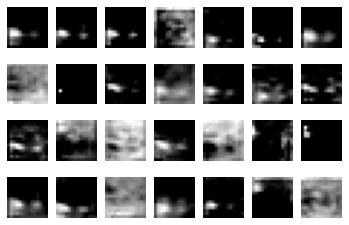

In [7]:
#Visualize the input features of the attention mechanism
import matplotlib.pyplot as plt

for i in range(4):
    for j in range(7):
        plt.gray()
        plt.subplot(4,7,i * 7 + j + 1,frameon=False)
        plt.imshow(x[0][i * 7 + j].detach().numpy())
        plt.axis('off')
        
plt.savefig('features.png',dpi = 300)

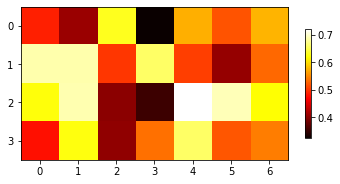

In [8]:
#Calculate and visualize spatial attention map
import matplotlib.pyplot as plt

ca_map = np.reshape(model.eres.ca(x).detach().numpy(),(4,7))
plt.imshow(ca_map,cmap = plt.cm.hot)
plt.colorbar(shrink=0.5)
plt.savefig('channel_attention.png',dpi = 300)

In [9]:
#Calculate spatial attention map
x = model.eres.ca(x) * x
spa_map = cv2.resize(model.eres.spa(x)[0][0].detach().numpy(),(112,112))
x = model.eres.spa(x) * x

In [10]:
#Calculate the self attention maps, and then aggregate them by a maximization operation
sa_map = None
for b in model.eres.sa.sa_blocks:
    m = b(x)[0]
    if sa_map is None:
        sa_map = m
    else:
        sa_map = torch.cat((sa_map,m),axis = 1)
sa_map = torch.max(sa_map[0],dim = 0)[0].detach().numpy()
sa_map = cv2.resize(cv2.GaussianBlur(sa_map,(3,3),0),(112,112))

In [11]:
#Normalize the spatial and self attention maps
def norm(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

spa_map = norm(spa_map)
sa_map = norm(sa_map)

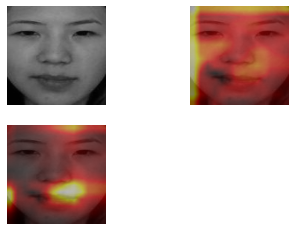

In [12]:
#Visualize the spatial attention, and the integration of spatial attention adn self attention
import cv2

raw = raw_dataset.df.at[sample_num,'OpticalFlow'][1]
raw = cv2.cvtColor(raw,cv2.COLOR_GRAY2RGB)
plt.subplot(2,2,1)
plt.imshow(raw)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(raw)
plt.imshow(spa_map,alpha = 0.5,cmap = plt.cm.hot)
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(raw)
plt.imshow(spa_map * sa_map,alpha = 0.5,cmap = plt.cm.hot)
plt.axis('off')

plt.savefig('spatial_self_attention.png',dpi = 400)